In [1]:
import xarray as xr
import numpy as np
from scipy import ndimage
import skimage as skimage
import matplotlib.pyplot as plt

In [2]:
#Import simulation
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_206x206/' #Path for Daint

In [3]:
#Read Data
d2D = xr.open_mfdataset(path+'output/lfff????????.nc', combine='by_coords')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [5]:
d2D

<xarray.Dataset>
Dimensions:       (bnds: 2, level1: 75, rlat: 206, rlon: 206, soil1: 10, srlat: 206, srlon: 206, time: 2400)
Coordinates:
  * rlon          (rlon) float32 0.0 0.03 0.06 ... 6.0899997 6.12 6.15
  * rlat          (rlat) float32 0.0 0.03 0.06 ... 6.0899997 6.12 6.15
  * srlon         (srlon) float32 0.015 0.044999998 ... 6.1349998 6.165
  * srlat         (srlat) float32 0.015 0.044999998 ... 6.1349998 6.165
    lon           (rlat, rlon) float32 -5.008956e-06 0.029994989 ... 6.149995
    lat           (rlat, rlon) float32 -2.504478e-06 ... 6.1499977
    height_2m     float32 2.0
    height_toa    float32 33250.0
  * soil1         (soil1) float32 0.005 0.025 0.07 0.16 ... 1.47 2.86 5.74 11.5
  * time          (time) datetime64[ns] 2011-07-12T12:00:00 ... 2011-10-20T11:00:00
Dimensions without coordinates: bnds, level1
Data variables:
    time_bnds     (time, bnds) datetime64[ns] dask.array<shape=(2400, 2), chunksize=(1, 2)>
    rotated_pole  (time) |S1 b'' b'' b'' b'' b'' 

In [12]:
def calc_curv(x, y, dx = 7):
    
    # determine equally spaced points along the contour
    
    xd = np.gradient(x)
    yd = np.gradient(y)
    dist = np.sqrt(xd**2+yd**2)
    u = np.cumsum(dist)
    u = np.hstack([[0],u])

    t = np.arange(0,u.max(), 7) # use effective resolution (7 grid spacings)
    xn = np.interp(t, u, x)
    yn = np.interp(t, u, y)
    
    # curvature calculation
    
    curv = (np.gradient(xn)*np.gradient(np.gradient(yn)) - np.gradient(yn)*np.gradient(np.gradient(xn)))/(np.gradient(xn)**2+np.gradient(yn)**2)**1.5

    return xn, yn, curv

In [5]:
#Mask of all moist regions
bFMSE = np.where(d2D.FMSE > np.median(d2D.FMSE, axis=(1,2))[:, np.newaxis, np.newaxis], 1, 0)

In [6]:
c = skimage.measure.find_contours(bFMSE[-260,:,:,], 0)

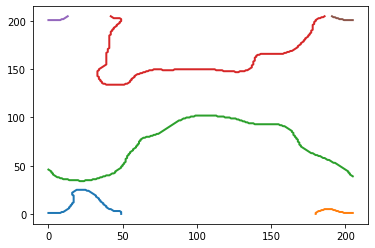

In [7]:
for n, contour in enumerate(c):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [14]:
c_old = skimage.measure.find_contours(bFMSE[-374,:,:,], 0)
x_old = c_old[-1][:, 1]
y_old = c_old[-1][:, 0]
xn_old, yn_old, curv_old = calc_curv(x_old, y_old)

plt.figure(figsize = (5, 5))

for i_t in range(-500, -380, 6): 
    
    print(i_t)
    
    c = skimage.measure.find_contours(bFMSE[i_t,:,:,], 0)
    
    contour = c[-1]
    
    x = contour[:, 1]
    y = contour[:, 0]
    
    xn, yn, curv = calc_curv(x, y)
    
    # Determine point of maximal curvature
    
    xn_max = xn[np.argmax(np.abs(curv))]
    yn_max = yn[np.argmax(np.abs(curv))]
    
    # Determine point of minimal distance 
    
    distance = np.sqrt((xn_old-xn_max)**2+(yn_old-yn_max)**2)
    print(np.min(distance))
    
    xn_max_old, yn_max_old = xn_old[np.argmin(distance)], yn_old[np.argmin(distance)]
    
    xn_old = np.copy(xn)
    yn_old = np.copy(yn)
    
    plt.plot(xn, yn, 'C0', alpha = 0.2)
    plt.scatter(xn_max, yn_max, c = 'r')
    plt.scatter(xn_max_old, yn_max_old, c = 'k')


ValueError: fp and xp are not of the same length.

In [9]:
x = contour[:, 1]
y = contour[:, 0]

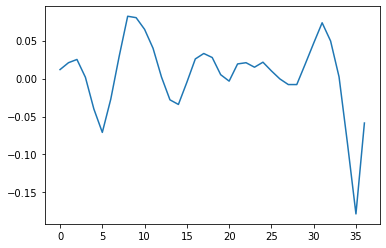

In [10]:
plt.plot((curv))

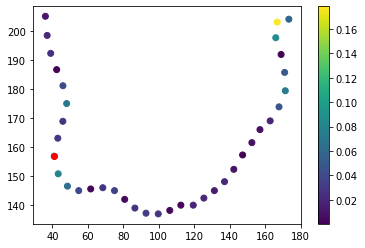

In [13]:
plt.scatter(xn, yn, c = np.abs(curv))
plt.colorbar()
plt.scatter(xn[np.argmax(curv)], yn[np.argmax(curv)], c = 'r')